# Module 13: Regularization Techniques

**Preventing Overfitting**

---

## Objectives

By the end of this notebook, you will:
- Understand overfitting and underfitting
- Master L1 and L2 regularization
- Implement and understand Dropout
- Know when to use each technique

**Prerequisites:** [Module 12 - Training Pipeline](../12_training_pipeline/12_training_pipeline.ipynb)

---

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

---

# Part 1: Understanding Overfitting

---

## 1.1 The Problem

- **Underfitting**: Model is too simple, high bias, poor on both train and test
- **Overfitting**: Model memorizes training data, high variance, poor on test
- **Good fit**: Generalizes well to unseen data

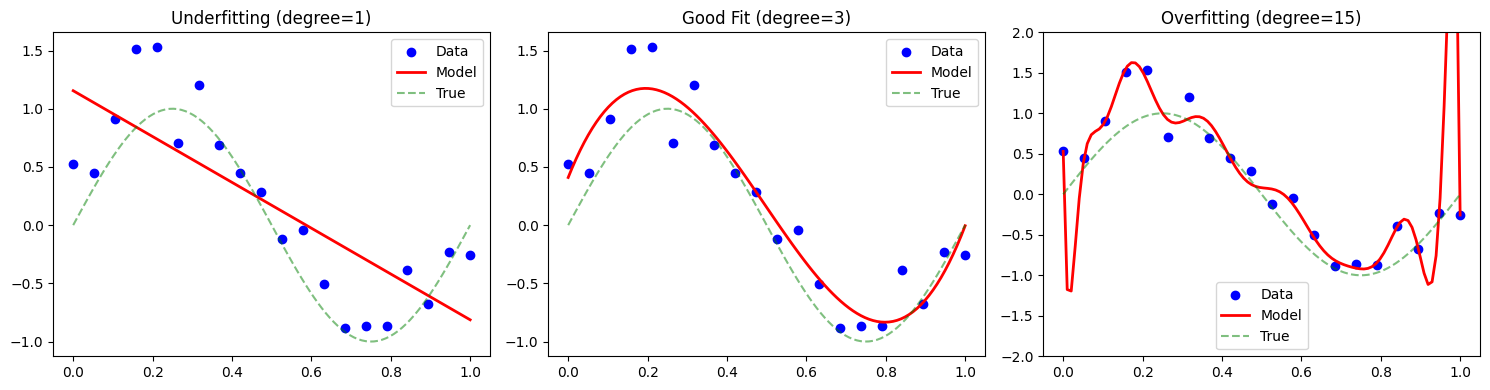

In [10]:
# Visualize overfitting
np.random.seed(0)
X = np.linspace(0, 1, 20)
y_true = np.sin(2 * np.pi * X)
y = y_true + np.random.randn(20) * 0.3

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

X_test = np.linspace(0, 1, 100)
y_test = np.sin(2 * np.pi * X_test)

# Underfitting (degree 1)
coef = np.polyfit(X, y, 1)
axes[0].scatter(X, y, c='blue', label='Data')
axes[0].plot(X_test, np.polyval(coef, X_test), 'r-', lw=2, label='Model')
axes[0].plot(X_test, y_test, 'g--', alpha=0.5, label='True')
axes[0].set_title('Underfitting (degree=1)')
axes[0].legend()

# Good fit (degree 3)
coef = np.polyfit(X, y, 3)
axes[1].scatter(X, y, c='blue', label='Data')
axes[1].plot(X_test, np.polyval(coef, X_test), 'r-', lw=2, label='Model')
axes[1].plot(X_test, y_test, 'g--', alpha=0.5, label='True')
axes[1].set_title('Good Fit (degree=3)')
axes[1].legend()

# Overfitting (degree 15)
coef = np.polyfit(X, y, 15)
axes[2].scatter(X, y, c='blue', label='Data')
axes[2].plot(X_test, np.polyval(coef, X_test), 'r-', lw=2, label='Model')
axes[2].plot(X_test, y_test, 'g--', alpha=0.5, label='True')
axes[2].set_title('Overfitting (degree=15)')
axes[2].set_ylim(-2, 2)
axes[2].legend()

plt.tight_layout()
plt.show()

---

# Part 2: L2 Regularization (Weight Decay)

---

## 2.1 The Idea

Add penalty for large weights:

$$L_{total} = L_{data} + \lambda \sum_{i} w_i^2$$

This encourages smaller weights, simpler models.

In [11]:
# L2 regularization in PyTorch
model = nn.Linear(10, 1)

# Method 1: weight_decay in optimizer (most common)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

print("weight_decay=0.01 means λ=0.01 for L2 regularization")

weight_decay=0.01 means λ=0.01 for L2 regularization


In [12]:
# Method 2: Manual L2 penalty
def l2_penalty(model, lambda_l2):
    l2_reg = 0
    for param in model.parameters():
        l2_reg += torch.sum(param ** 2)
    return lambda_l2 * l2_reg

# In training loop:
# loss = criterion(output, target) + l2_penalty(model, 0.01)

model = nn.Linear(10, 1)
print(f"L2 penalty: {l2_penalty(model, 0.01).item():.4f}")

L2 penalty: 0.0020


---

# Part 3: L1 Regularization

---

$$L_{total} = L_{data} + \lambda \sum_{i} |w_i|$$

Encourages sparsity (some weights become exactly zero).

In [13]:
def l1_penalty(model, lambda_l1):
    l1_reg = 0
    for param in model.parameters():
        l1_reg += torch.sum(torch.abs(param))
    return lambda_l1 * l1_reg

# Usage in training:
# loss = criterion(output, target) + l1_penalty(model, 0.001)

model = nn.Linear(10, 1)
print(f"L1 penalty: {l1_penalty(model, 0.001).item():.4f}")

L1 penalty: 0.0022


### L1 vs L2 Comparison

| | L1 | L2 |
|---|---|---|
| Effect | Sparse weights | Small weights |
| Use case | Feature selection | General regularization |
| PyTorch | Manual | weight_decay |

---

# Part 4: Dropout

---

## 4.1 How It Works

During training, randomly set some activations to zero:

$$y = \frac{1}{1-p} \cdot x \cdot \text{mask}$$

Where mask is 0 with probability p, else 1.

In [14]:
# Dropout from scratch
def dropout_scratch(x, p, training):
    if not training or p == 0:
        return x

    mask = (torch.rand_like(x) > p).float()
    return x * mask / (1 - p)  # Scale to maintain expected value

x = torch.ones(1, 10)
print(f"Original: {x}")
print(f"Dropout (p=0.5): {dropout_scratch(x, 0.5, training=True)}")

Original: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
Dropout (p=0.5): tensor([[2., 0., 2., 2., 2., 2., 0., 2., 0., 2.]])


In [15]:
# PyTorch Dropout
dropout = nn.Dropout(p=0.5)

x = torch.ones(1, 10)

# Training mode
dropout.train()
print(f"Training: {dropout(x)}")

# Eval mode - dropout disabled
dropout.eval()
print(f"Eval:     {dropout(x)}")

Training: tensor([[0., 2., 0., 0., 2., 2., 0., 0., 2., 2.]])
Eval:     tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [16]:
# Using dropout in a network
class MLPWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)  # Dropout after activation
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # No dropout before output
        return x

model = MLPWithDropout(784, 256, 10, dropout_rate=0.5)
print(f"Model with dropout: {sum(p.numel() for p in model.parameters()):,} params")

Model with dropout: 269,322 params


## 4.2 Dropout Guidelines

- Typical rates: 0.2 - 0.5
- Apply after activation functions
- Don't apply to output layer
- Use higher rates for larger networks

---

# Key Points Summary

---

## L2 Regularization (Weight Decay)
- Penalizes large weights: $\lambda\sum w^2$
- Use `weight_decay` in optimizer
- Typical values: 0.0001 - 0.01

## L1 Regularization
- Encourages sparsity: $\lambda\sum|w|$
- Implement manually in loss function
- Good for feature selection

## Dropout
- Randomly zero activations during training
- Disabled during evaluation (`model.eval()`)
- Typical rates: 0.2 - 0.5

---

# Interview Tips

---

**Q: What is the difference between L1 and L2 regularization?**
A: L2 (weight decay) penalizes the square of weights, resulting in small but non-zero weights. L1 penalizes absolute values, often resulting in exactly zero weights (sparsity). L2 is more common for general regularization; L1 is useful for feature selection.

**Q: How does dropout prevent overfitting?**
A: By randomly dropping neurons during training, the network can't rely on any single feature. This forces it to learn redundant representations, making it more robust and less likely to memorize training data.

**Q: Why is dropout disabled during evaluation?**
A: During evaluation, we want deterministic predictions. Dropout is a regularization technique for training only. The scaling factor (1/(1-p)) during training ensures expected values match at test time.

---

## Next Module: [14 - Weight Initialization](../14_weight_init/14_weight_init.ipynb)